In [2]:
# Import necessary libraries
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Set paths for data, pickle files, and outputs
DATA_PATH_TRAIN = 'C:/Users/SHRI/Documents/DS/DS_Projects/Employment_Analysis/data/train_features.csv'
DATA_PATH_TEST = 'C:/Users/SHRI/Documents/DS/DS_Projects/Employment_Analysis/data/test_features.csv'
OUTPUT_PATH = 'C:/Users/SHRI/Documents/DS/DS_Projects/Employment_Analysis/outputs/feature_importance'
LABEL_ENCODER_PATH = 'C:/Users/SHRI/Documents/DS/DS_Projects/Employment_Analysis/models/label_encoder.pkl'
SCALER_PATH = 'C:/Users/SHRI/Documents/DS/DS_Projects/Employment_Analysis/models/scaler.pkl'

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Load the training and test data
train_data = pd.read_csv(DATA_PATH_TRAIN)
test_data = pd.read_csv(DATA_PATH_TEST)

# Check data loaded correctly
print(f"Train Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")


Train Data Shape: (39722, 42)
Test Data Shape: (9931, 42)


In [3]:
# Load the LabelEncoder and Scaler from pickle files
with open(LABEL_ENCODER_PATH, 'rb') as le_file:
    label_encoder = pickle.load(le_file)

with open(SCALER_PATH, 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

# Check if the label_encoder and scaler are loaded correctly
print("Label Encoder and Scaler loaded successfully.")


Label Encoder and Scaler loaded successfully.


In [9]:
from sklearn.preprocessing import LabelEncoder

# Instantiate a LabelEncoder for each column
label_encoders = {col: LabelEncoder() for col in categorical_columns}

# Fit on train data and transform train data
for col in categorical_columns:
    label_encoders[col].fit(train_data[col])

    # Transform train data
    train_data[col] = label_encoders[col].transform(train_data[col])

    # Transform test data with a fallback for unseen labels
    test_data[col] = test_data[col].apply(
        lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1
    )

print(f"Categorical features after encoding: {categorical_columns}")


Categorical features after encoding: Index(['orighiredate_key', 'terminationdate_key', 'city_name',
       'termreason_desc', 'termtype_desc', 'BUSINESS_UNIT', 'CLASS',
       'last_promotion_date'],
      dtype='object')


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Identify numerical columns
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns

# Instantiate and fit the scaler on train data
scaler = MinMaxScaler()
scaler.fit(train_data[numerical_columns])

# Transform train and test data
train_data[numerical_columns] = scaler.transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

print(f"Numerical features after scaling: {numerical_columns}")


Numerical features after scaling: Index(['EmployeeID', 'orighiredate_key', 'terminationdate_key', 'age',
       'length_of_service', 'city_name', 'department_name', 'job_title',
       'store_name', 'gender_full', 'termreason_desc', 'termtype_desc',
       'STATUS_YEAR', 'BUSINESS_UNIT', 'GENERAL APPEARANCE',
       'MANNER OF SPEAKING', 'PHYSICAL CONDITION', 'MENTAL ALERTNESS',
       'SELF-CONFIDENCE', 'ABILITY TO PRESENT IDEAS', 'COMMUNICATION SKILLS',
       'Student Performance Rating', 'CLASS', 'salary', 'last_promotion_date',
       'performance_score', 'manager_rating', 'self_rating',
       'work_life_balance_score', 'overtime_hours', 'working_hours',
       'employee_satisfaction_score', 'salary_hike_percent',
       'post_promotion_performance', 'peer_feedback_score', 'absenteeism_rate',
       'tenure_bucket', 'months_since_last_promotion', 'turnover_risk_index',
       'engagement_index', 'absenteeism_category', 'performance_improvement'],
      dtype='object')


In [6]:
# Load target variables (Attrition and STATUS)
target_attrition_train = pd.read_csv('C:/Users/SHRI/Documents/DS/DS_Projects/Employment_Analysis/data/train_target_attrition.csv')
target_status_train = pd.read_csv('C:/Users/SHRI/Documents/DS/DS_Projects/Employment_Analysis/data/train_target_status.csv')

target_attrition_test = pd.read_csv('C:/Users/SHRI/Documents/DS/DS_Projects/Employment_Analysis/data/test_target_attrition.csv')
target_status_test = pd.read_csv('C:/Users/SHRI/Documents/DS/DS_Projects/Employment_Analysis/data/test_target_status.csv')

# Print shapes to confirm
print(f"Train Attrition Target Shape: {target_attrition_train.shape}")
print(f"Train STATUS Target Shape: {target_status_train.shape}")


Train Attrition Target Shape: (39722, 1)
Train STATUS Target Shape: (39722, 1)


In [7]:
# For this step, use all features to calculate importance
X_train = train_data
X_test = test_data

# For RandomForest, XGBoost, we will use the 'Attrition' and 'STATUS' as target variables
y_train_attrition = target_attrition_train
y_train_status = target_status_train

# Check the feature set
print(f"Feature Set for Training: {X_train.columns}")


Feature Set for Training: Index(['EmployeeID', 'orighiredate_key', 'terminationdate_key', 'age',
       'length_of_service', 'city_name', 'department_name', 'job_title',
       'store_name', 'gender_full', 'termreason_desc', 'termtype_desc',
       'STATUS_YEAR', 'BUSINESS_UNIT', 'GENERAL APPEARANCE',
       'MANNER OF SPEAKING', 'PHYSICAL CONDITION', 'MENTAL ALERTNESS',
       'SELF-CONFIDENCE', 'ABILITY TO PRESENT IDEAS', 'COMMUNICATION SKILLS',
       'Student Performance Rating', 'CLASS', 'salary', 'last_promotion_date',
       'performance_score', 'manager_rating', 'self_rating',
       'work_life_balance_score', 'overtime_hours', 'working_hours',
       'employee_satisfaction_score', 'salary_hike_percent',
       'post_promotion_performance', 'peer_feedback_score', 'absenteeism_rate',
       'tenure_bucket', 'months_since_last_promotion', 'turnover_risk_index',
       'engagement_index', 'absenteeism_category', 'performance_improvement'],
      dtype='object')


In [11]:
# Initialize and train RandomForestRegressor for Attrition target
print("Calculating feature importance using RandomForest for Attrition...")
rf_model_attrition = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_attrition.fit(X_train, y_train_attrition)

# Extract feature importances from the RandomForest model
rf_importances_attrition = rf_model_attrition.feature_importances_

# Create a DataFrame of feature importances
rf_feature_importances_attrition = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_importances_attrition
}).sort_values(by='Importance', ascending=False)

# Save feature importances to CSV
rf_importance_file_attrition = os.path.join(OUTPUT_PATH, 'rf_feature_importance_attrition.csv')
rf_feature_importances_attrition.to_csv(rf_importance_file_attrition, index=False)
print(f"RandomForest feature importance saved for Attrition: {rf_importance_file_attrition}")

# Display top 10 features for Attrition
rf_feature_importances_attrition.head(10)


Calculating feature importance using RandomForest for Attrition...


c:\Users\SHRI\Documents\DS\DS_Projects\Employment_Analysis\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForest feature importance saved for Attrition: C:/Users/SHRI/Documents/DS/DS_Projects/Employment_Analysis/outputs/feature_importance\rf_feature_importance_attrition.csv


,Feature,Importance
23,salary,0.070354
38,turnover_risk_index,0.053988
39,engagement_index,0.051663
28,work_life_balance_score,0.050658
0,EmployeeID,0.047200
29,overtime_hours,0.044883
26,manager_rating,0.044662
41,performance_improvement,0.043323
25,performance_score,0.041022
27,self_rating,0.039797


In [12]:
# Initialize and train XGBoost for Attrition target
print("Calculating feature importance using XGBoost for Attrition...")
xgb_model_attrition = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model_attrition.fit(X_train, y_train_attrition)

# Extract feature importances from the XGBoost model
xgb_importances_attrition = xgb_model_attrition.feature_importances_

# Create a DataFrame of feature importances
xgb_feature_importances_attrition = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_importances_attrition
}).sort_values(by='Importance', ascending=False)

# Save feature importances to CSV
xgb_importance_file_attrition = os.path.join(OUTPUT_PATH, 'xgb_feature_importance_attrition.csv')
xgb_feature_importances_attrition.to_csv(xgb_importance_file_attrition, index=False)
print(f"XGBoost feature importance saved for Attrition: {xgb_importance_file_attrition}")

# Display top 10 features for Attrition
xgb_feature_importances_attrition.head(10)


Calculating feature importance using XGBoost for Attrition...
XGBoost feature importance saved for Attrition: C:/Users/SHRI/Documents/DS/DS_Projects/Employment_Analysis/outputs/feature_importance\xgb_feature_importance_attrition.csv


,Feature,Importance
13,BUSINESS_UNIT,0.030504
9,gender_full,0.028428
35,absenteeism_rate,0.028133
33,post_promotion_performance,0.027159
36,tenure_bucket,0.026732
12,STATUS_YEAR,0.026672
38,turnover_risk_index,0.026656
29,overtime_hours,0.026653
32,salary_hike_percent,0.026639
27,self_rating,0.025952


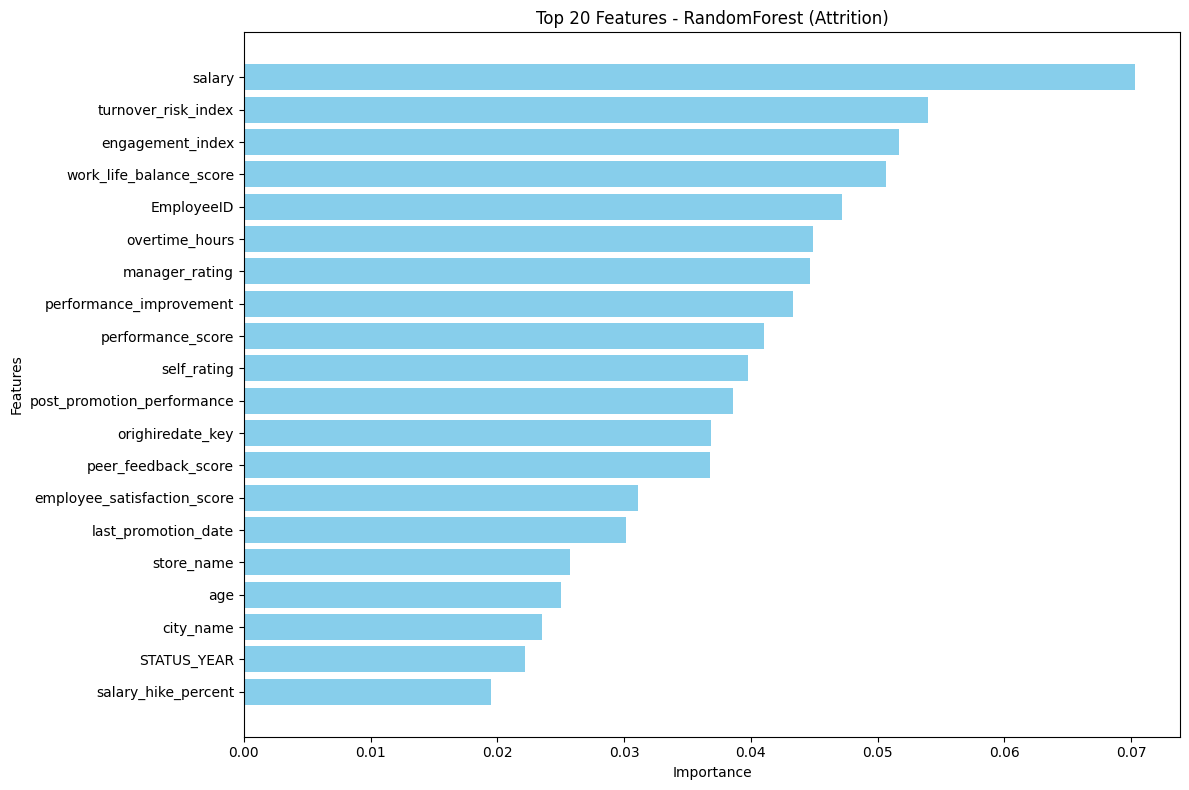

<Figure size 640x480 with 0 Axes>

In [17]:
# Plot RandomForest Feature Importances for Attrition
plt.figure(figsize=(12, 8))
top_features_rf_status = rf_feature_importances_attrition.head(20)  # Top 20 features
plt.barh(top_features_rf_status['Feature'], top_features_rf_status['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Features - RandomForest (Attrition)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'Top_20_Features_RandomForest_(Attrition).png'))

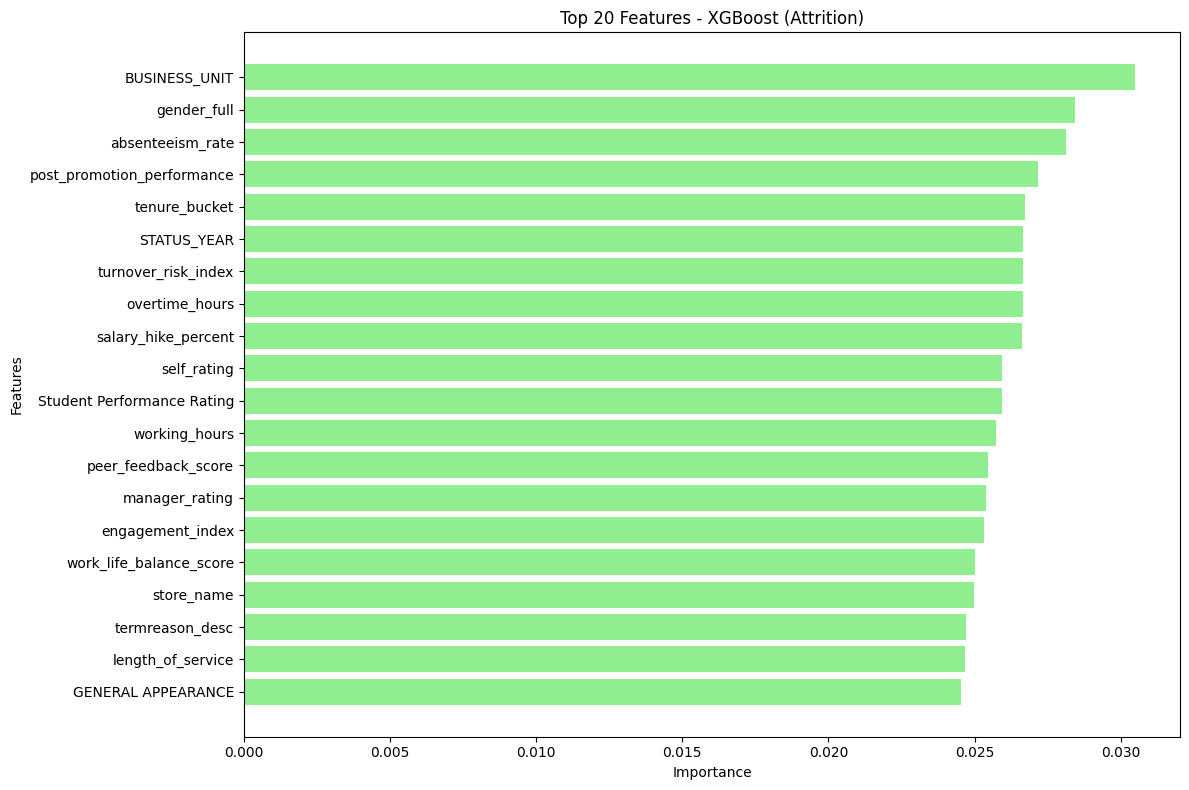

<Figure size 640x480 with 0 Axes>

In [18]:
# Plot XGBoost Feature Importances for STATUS
plt.figure(figsize=(12, 8))
top_features_xgb_status = xgb_feature_importances_attrition.head(20)  # Top 20 features
plt.barh(top_features_xgb_status['Feature'], top_features_xgb_status['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Features - XGBoost (Attrition)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'Top_20_Features_XGBoost_(Attrtion).png'))

In [13]:
# Initialize and train RandomForestRegressor for STATUS target
print("Calculating feature importance using RandomForest for STATUS...")
rf_model_status = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_status.fit(X_train, y_train_status)

# Extract feature importances from the RandomForest model
rf_importances_status = rf_model_status.feature_importances_

# Create a DataFrame of feature importances
rf_feature_importances_status = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_importances_status
}).sort_values(by='Importance', ascending=False)

# Save feature importances to CSV
rf_importance_file_status = os.path.join(OUTPUT_PATH, 'rf_feature_importance_status.csv')
rf_feature_importances_status.to_csv(rf_importance_file_status, index=False)
print(f"RandomForest feature importance saved for STATUS: {rf_importance_file_status}")

# Display top 10 features for STATUS
rf_feature_importances_status.head(10)


Calculating feature importance using RandomForest for STATUS...


c:\Users\SHRI\Documents\DS\DS_Projects\Employment_Analysis\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForest feature importance saved for STATUS: C:/Users/SHRI/Documents/DS/DS_Projects/Employment_Analysis/outputs/feature_importance\rf_feature_importance_status.csv


,Feature,Importance
0,EmployeeID,0.118050
23,salary,0.063260
38,turnover_risk_index,0.051006
39,engagement_index,0.046472
28,work_life_balance_score,0.046088
26,manager_rating,0.042402
29,overtime_hours,0.041445
41,performance_improvement,0.039806
27,self_rating,0.038534
25,performance_score,0.037512


In [14]:
# Initialize and train XGBoost for STATUS target
print("Calculating feature importance using XGBoost for STATUS...")
xgb_model_status = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model_status.fit(X_train, y_train_status)

# Extract feature importances from the XGBoost model
xgb_importances_status = xgb_model_status.feature_importances_

# Create a DataFrame of feature importances
xgb_feature_importances_status = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_importances_status
}).sort_values(by='Importance', ascending=False)

# Save feature importances to CSV
xgb_importance_file_status = os.path.join(OUTPUT_PATH, 'xgb_feature_importance_status.csv')
xgb_feature_importances_status.to_csv(xgb_importance_file_status, index=False)
print(f"XGBoost feature importance saved for STATUS: {xgb_importance_file_status}")

# Display top 10 features for STATUS
xgb_feature_importances_status.head(10)


Calculating feature importance using XGBoost for STATUS...
XGBoost feature importance saved for STATUS: C:/Users/SHRI/Documents/DS/DS_Projects/Employment_Analysis/outputs/feature_importance\xgb_feature_importance_status.csv


,Feature,Importance
10,termreason_desc,0.101391
0,EmployeeID,0.090742
37,months_since_last_promotion,0.024297
16,PHYSICAL CONDITION,0.024273
18,SELF-CONFIDENCE,0.023851
9,gender_full,0.023640
39,engagement_index,0.023395
22,CLASS,0.023238
36,tenure_bucket,0.023149
34,peer_feedback_score,0.023118


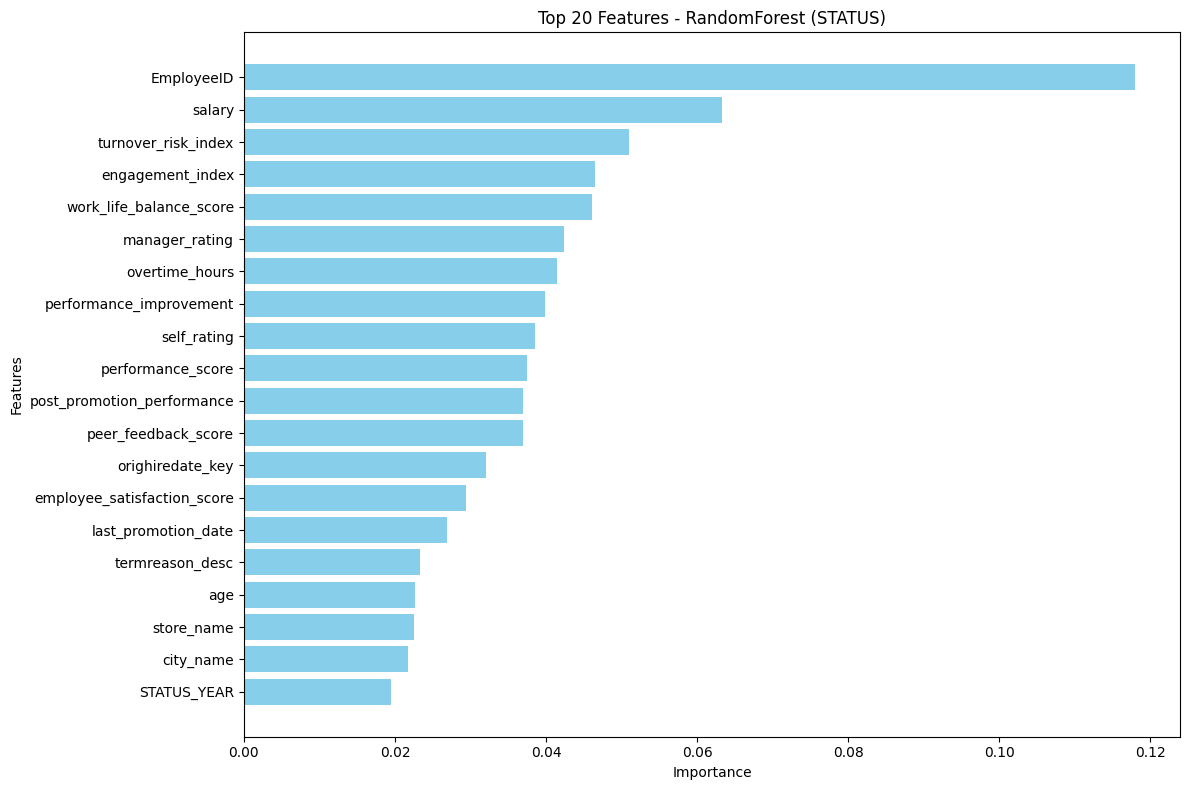

<Figure size 640x480 with 0 Axes>

In [15]:
# Plot RandomForest Feature Importances for STATUS
plt.figure(figsize=(12, 8))
top_features_rf_status = rf_feature_importances_status.head(20)  # Top 20 features
plt.barh(top_features_rf_status['Feature'], top_features_rf_status['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Features - RandomForest (STATUS)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'Top_20_Features_RandomForest_(STATUS).png'))

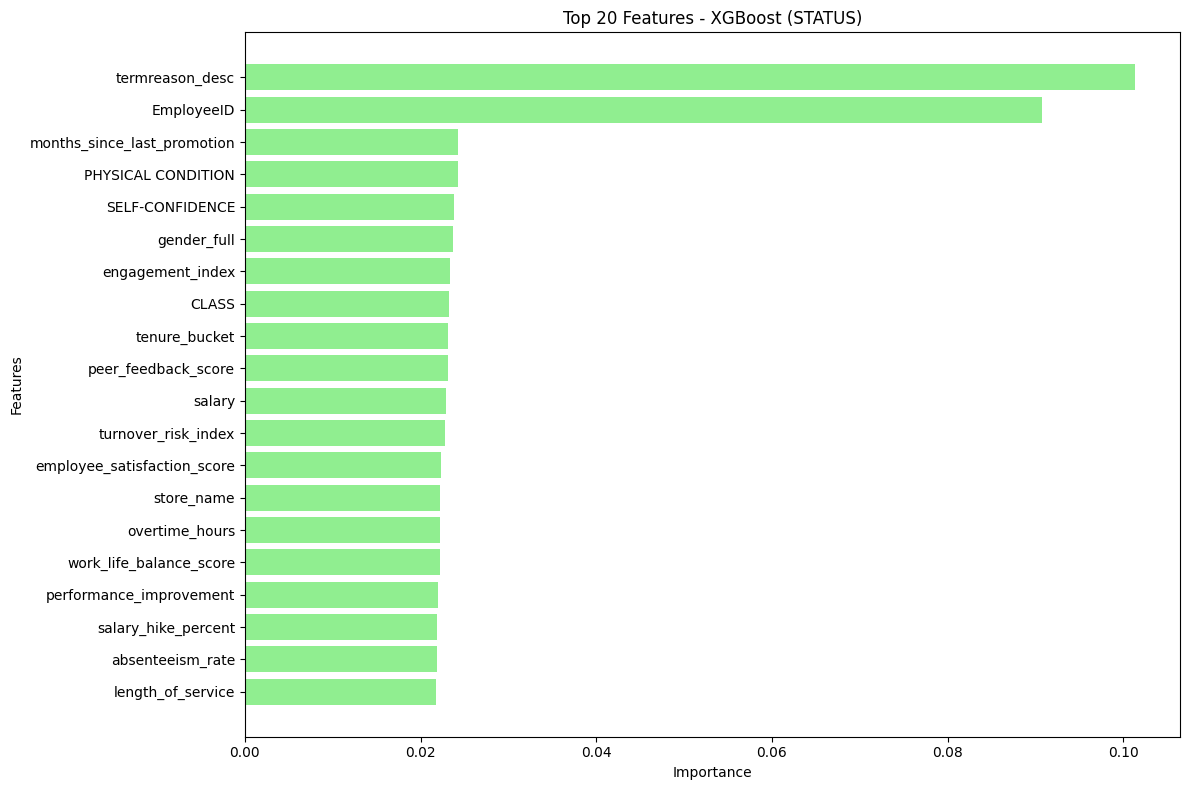

<Figure size 640x480 with 0 Axes>

In [16]:
# Plot XGBoost Feature Importances for STATUS
plt.figure(figsize=(12, 8))
top_features_xgb_status = xgb_feature_importances_status.head(20)  # Top 20 features
plt.barh(top_features_xgb_status['Feature'], top_features_xgb_status['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Features - XGBoost (STATUS)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'Top_20_Features_XGBoost_(STATUS).png'))